In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf


from scipy.io import loadmat  # this is the SciPy module that loads mat-files
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from time import time

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.7.0


In [ ]:
mat = loadmat('/content/drive/MyDrive/Colab Notebooks/train.mat')  # load mat-file
x, y = mat['X'], mat['y']  # variable in mat file
npx, npy = np.array(x), np.array(y)

print('test')
print(x.shape, y.shape)
print(npx.shape, npy.shape)

mat = loadmat('/content/drive/MyDrive/Colab Notebooks/test.mat')  # load mat-file
x, y = mat['X'], mat['y']  # variable in mat file
npx = np.concatenate((npx, np.array(x)), axis=3)
npy = np.concatenate((npy, np.array(y)), axis=0)

print('+train')
print(x.shape, y.shape)
print(npx.shape, npy.shape)

npx = np.array([npx[:,:,:,i] for i in range(npx.shape[3])])
print('final')
print(npx.shape, npy.shape)

test
(32, 32, 3, 73257) (73257, 1)
(32, 32, 3, 73257) (73257, 1)
+train
(32, 32, 3, 26032) (26032, 1)
(32, 32, 3, 99289) (99289, 1)
final
(99289, 32, 32, 3) (99289, 1)


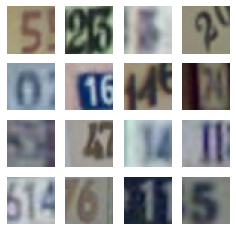

In [ ]:
fig = plt.figure(figsize=(4,4))
imgs = random.choices(npx, k=16)
for i in range(len(imgs)):
    plt.subplot(4, 4, i+1)
    plt.imshow(imgs[i])
    plt.axis('off')
plt.show()

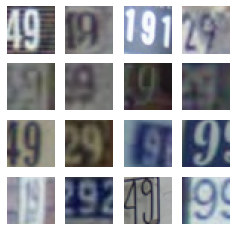

In [ ]:
indices = np.where(npy==9)[0]
x = npx[indices] / 255

fig = plt.figure(figsize=(4,4))
imgs = random.choices(x, k=16)
for i in range(len(imgs)):
    plt.subplot(4, 4, i+1)
    plt.imshow(imgs[i])
    plt.axis('off')
plt.show()

In [ ]:
x.shape, indices.shape

In [ ]:
discriminator = Sequential([
    Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=[32,32,3]),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False),

    Flatten(),
    Dense(1, activation='sigmoid'),
])

opt = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 16, 16, 64)        3136      
                                                                 
 batch_normalization_16 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 128)         131072    
                                                                 
 batch_normalization_17 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 8, 8, 128)        

In [ ]:
noise_size = 128
generator = Sequential([
    Dense(2*2*512, input_shape=[noise_size]),
    Reshape([2,2,512]),
                        
    Conv2DTranspose(512, kernel_size=4, strides=1, padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False),
    LeakyReLU(),
    BatchNormalization(),

    Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation='sigmoid'),
])

generator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 2048)              264192    
                                                                 
 reshape_2 (Reshape)         (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 2, 2, 512)        4194304   
 Transpose)                                                      
                                                                 
 batch_normalization_20 (Bat  (None, 2, 2, 512)        2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 4, 4, 256)       

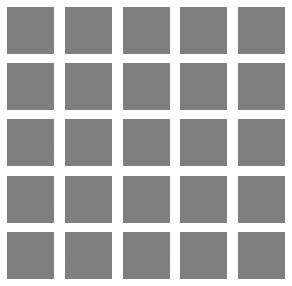

In [ ]:
num_examples = 25
seed = tf.random.normal([num_examples, noise_size])
fig = plt.figure(figsize=(5,5))
imgs = generator(seed, training=False)
for i in range(len(imgs)):
    plt.subplot(5, 5, i+1)
    img = np.array(imgs[i] * 255, dtype='uint')
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
input_layer = tf.keras.layers.Input(shape=(noise_size, ))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

gan = Model(
    input_layer,
    disc_out
)

discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128)]             0         
                                                                 
 sequential_5 (Sequential)   (None, 32, 32, 3)         7217923   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 6954305   
                                                                 
Total params: 14,172,228
Trainable params: 7,216,003
Non-trainable params: 6,956,225
_________________________________________________________________


In [ ]:
epochs = 50
delta = 0
batch_size = 256
half = int(batch_size/2)
steps_per_epoch = int(2 * x.shape[0]/batch_size)

print('Steps per epoch =', steps_per_epoch)

stat = {}

Steps per epoch = 48


		Epoch 0
24.535350799560547
gan_loss: 0.5792555809020996 gan_acc: 1.0
dis_loss: 0.7790044546127319 dis_acc: 0.53125


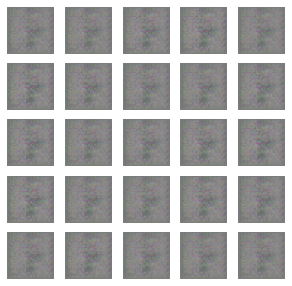

		Epoch 1
20.948572874069214
gan_loss: 0.010612836107611656 gan_acc: 1.0
dis_loss: 1.4785798788070679 dis_acc: 0.5


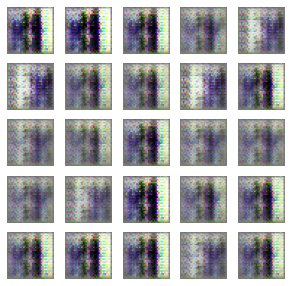

		Epoch 2
21.27478861808777
gan_loss: 0.0020733883138746023 gan_acc: 1.0
dis_loss: 2.2490437030792236 dis_acc: 0.5


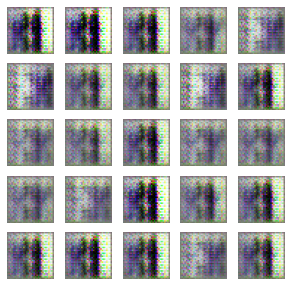

		Epoch 3
20.838403940200806
gan_loss: 0.0004895065794698894 gan_acc: 1.0
dis_loss: 3.166414260864258 dis_acc: 0.5


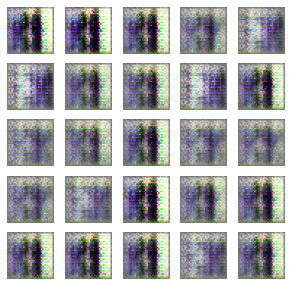

		Epoch 4
21.363954782485962
gan_loss: 0.00024168056552298367 gan_acc: 1.0
dis_loss: 3.8691580295562744 dis_acc: 0.5


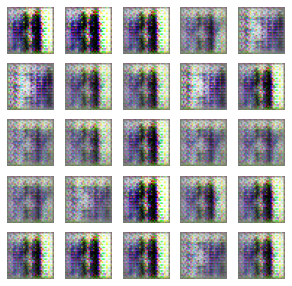

		Epoch 5
20.832265377044678
gan_loss: 0.00023891369346529245 gan_acc: 1.0
dis_loss: 4.36827278137207 dis_acc: 0.5


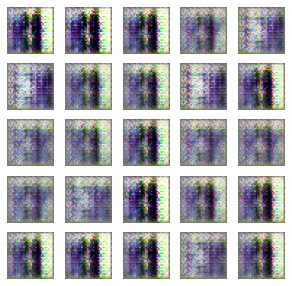

		Epoch 6
20.934016227722168
gan_loss: 6.319457315839827e-05 gan_acc: 1.0
dis_loss: 4.517760276794434 dis_acc: 0.5


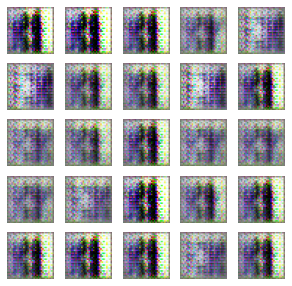

		Epoch 7
20.864008903503418
gan_loss: 0.00023732389672659338 gan_acc: 1.0
dis_loss: 4.68209171295166 dis_acc: 0.5


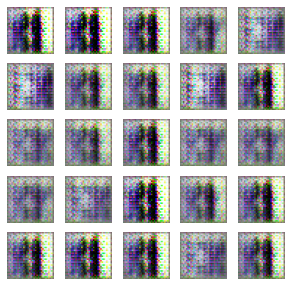

		Epoch 8
20.580747842788696
gan_loss: 0.00015269903815351427 gan_acc: 1.0
dis_loss: 4.391558647155762 dis_acc: 0.5


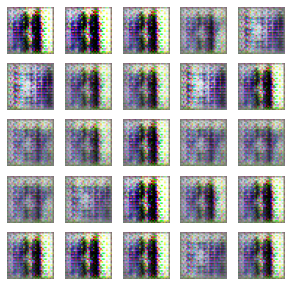

		Epoch 9
20.975390672683716
gan_loss: 2.0609011698979884e-05 gan_acc: 1.0
dis_loss: 4.300378799438477 dis_acc: 0.5


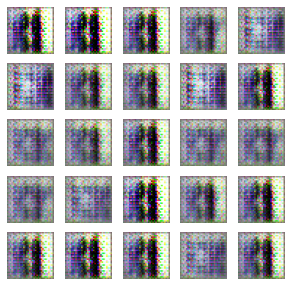

		Epoch 10
20.563634157180786
gan_loss: 0.00011029284360120073 gan_acc: 1.0
dis_loss: 3.6847879886627197 dis_acc: 0.5


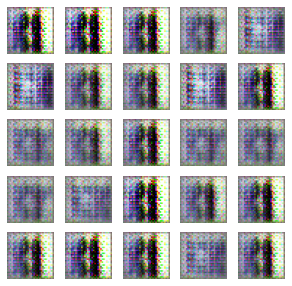

		Epoch 11
21.035468816757202
gan_loss: 0.0007345366175286472 gan_acc: 1.0
dis_loss: 3.001727342605591 dis_acc: 0.5


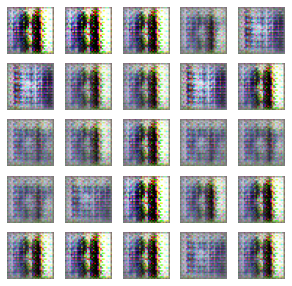

		Epoch 12
20.947340726852417
gan_loss: 4.316440026741475e-05 gan_acc: 1.0
dis_loss: 3.4607880115509033 dis_acc: 0.5


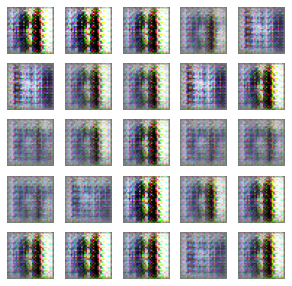

		Epoch 13
20.827598810195923
gan_loss: 0.00018310919404029846 gan_acc: 1.0
dis_loss: 2.8742289543151855 dis_acc: 0.5


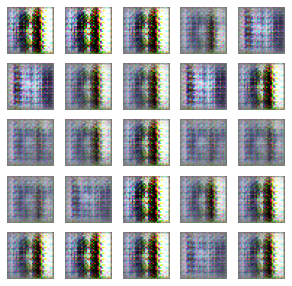

		Epoch 14
20.947933673858643
gan_loss: 89.30835723876953 gan_acc: 0.0
dis_loss: 120.774658203125 dis_acc: 0.5


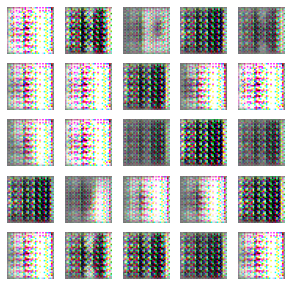

		Epoch 15
21.240670919418335
gan_loss: 11.453523635864258 gan_acc: 0.578125
dis_loss: 8.754816055297852 dis_acc: 0.62890625


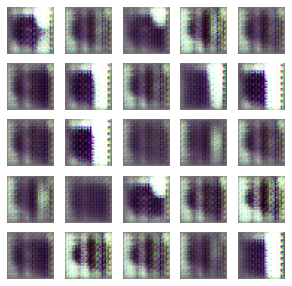

		Epoch 16
21.041253805160522
gan_loss: 2.112051486968994 gan_acc: 0.1796875
dis_loss: 5.815213203430176 dis_acc: 0.66796875


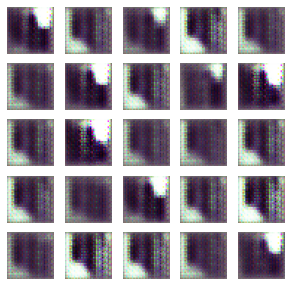

		Epoch 17
20.991906881332397
gan_loss: 0.844883382320404 gan_acc: 0.6640625
dis_loss: 5.781729698181152 dis_acc: 0.5234375


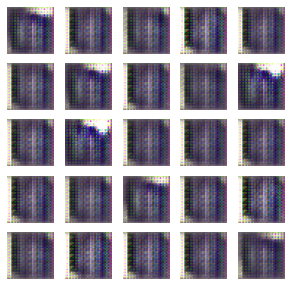

		Epoch 18
20.763262271881104
gan_loss: 0.4346502423286438 gan_acc: 0.8984375
dis_loss: 1.8524556159973145 dis_acc: 0.609375


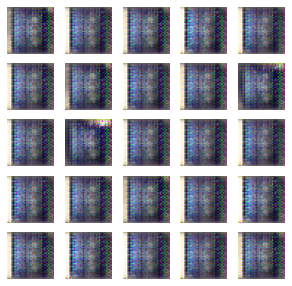

		Epoch 19
20.890541553497314
gan_loss: 0.18356403708457947 gan_acc: 1.0
dis_loss: 0.5727332234382629 dis_acc: 0.8125


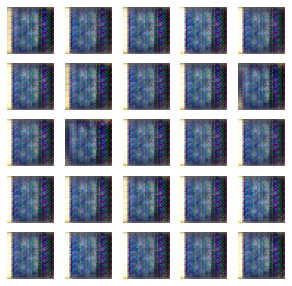

		Epoch 20
20.40589213371277
gan_loss: 0.21908333897590637 gan_acc: 1.0
dis_loss: 0.13904596865177155 dis_acc: 0.94140625


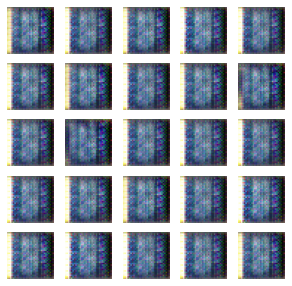

		Epoch 21
20.542300939559937
gan_loss: 0.047170914709568024 gan_acc: 1.0
dis_loss: 0.17207974195480347 dis_acc: 0.96875


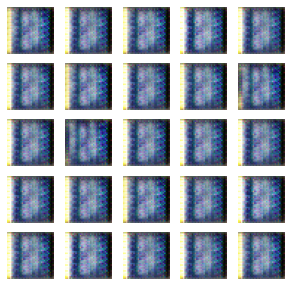

		Epoch 22
20.754434823989868
gan_loss: 0.12188771367073059 gan_acc: 0.9921875
dis_loss: 0.9010652899742126 dis_acc: 0.53125


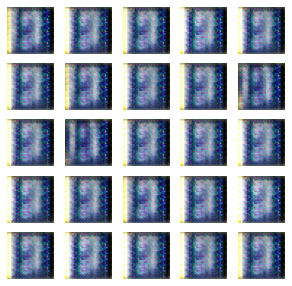

		Epoch 23
21.123507022857666
gan_loss: 0.4734020233154297 gan_acc: 0.8984375
dis_loss: 4.348108291625977 dis_acc: 0.52734375


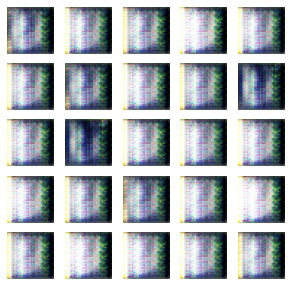

		Epoch 24
20.571526765823364
gan_loss: 4.462697505950928 gan_acc: 0.109375
dis_loss: 0.12692493200302124 dis_acc: 0.96484375


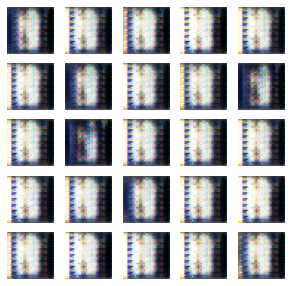

		Epoch 25
20.546812772750854
gan_loss: 0.12804973125457764 gan_acc: 0.96875
dis_loss: 1.1329755783081055 dis_acc: 0.51953125


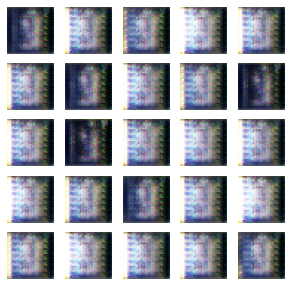

		Epoch 26
20.94808602333069
gan_loss: 0.00690778624266386 gan_acc: 1.0
dis_loss: 2.0359413623809814 dis_acc: 0.5


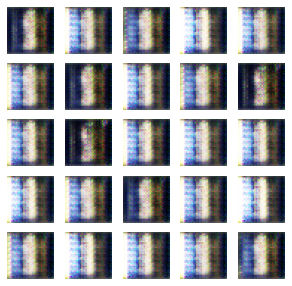

		Epoch 27
20.856875896453857
gan_loss: 0.13236351311206818 gan_acc: 1.0
dis_loss: 0.7143070697784424 dis_acc: 0.4921875


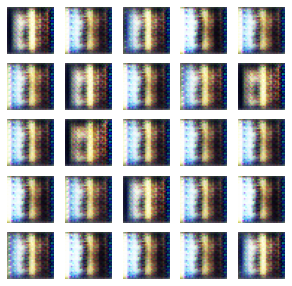

		Epoch 28
20.73574471473694
gan_loss: 0.03457149490714073 gan_acc: 1.0
dis_loss: 2.228938102722168 dis_acc: 0.5


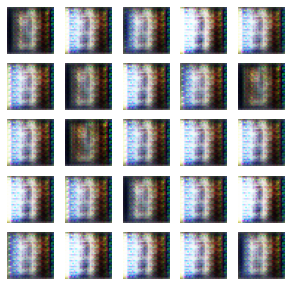

		Epoch 29
21.011388778686523
gan_loss: 0.006210664287209511 gan_acc: 1.0
dis_loss: 3.381657838821411 dis_acc: 0.5


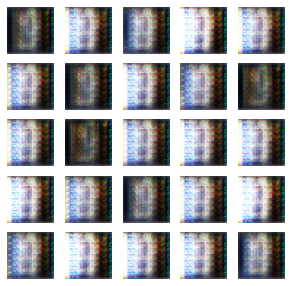

		Epoch 30
21.005489826202393
gan_loss: 0.022323239594697952 gan_acc: 0.9921875
dis_loss: 2.7712814807891846 dis_acc: 0.50390625


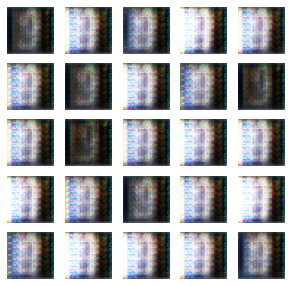

		Epoch 31
20.722177267074585
gan_loss: 0.005049433559179306 gan_acc: 1.0
dis_loss: 3.0169856548309326 dis_acc: 0.5


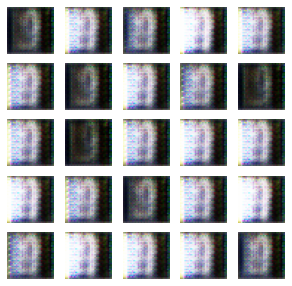

		Epoch 32
20.989242792129517
gan_loss: 0.024723796173930168 gan_acc: 1.0
dis_loss: 1.9664320945739746 dis_acc: 0.5


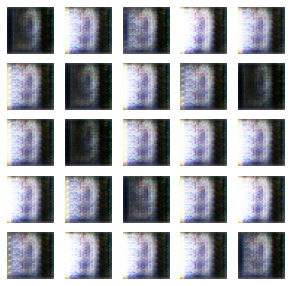

		Epoch 33
21.07724094390869
gan_loss: 0.016040517017245293 gan_acc: 1.0
dis_loss: 1.3279979228973389 dis_acc: 0.51171875


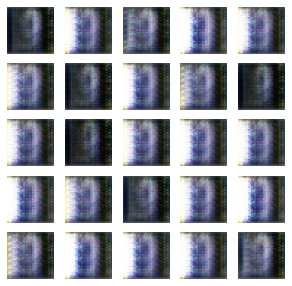

		Epoch 34
20.871031284332275
gan_loss: 2.6848422152170315e-08 gan_acc: 1.0
dis_loss: 6.042922019958496 dis_acc: 0.5078125


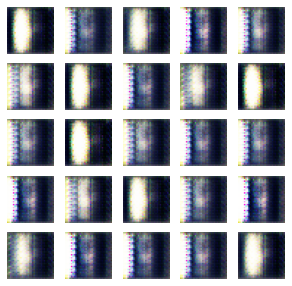

		Epoch 35
21.155439376831055
gan_loss: 1.1285106666036882e-05 gan_acc: 1.0
dis_loss: 4.191818714141846 dis_acc: 0.50390625


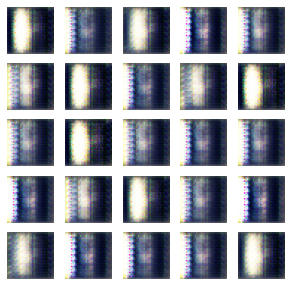

		Epoch 36
21.20583438873291
gan_loss: 0.0036451718769967556 gan_acc: 1.0
dis_loss: 2.0592188835144043 dis_acc: 0.51171875


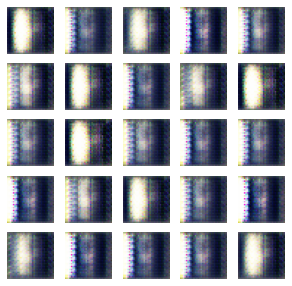

		Epoch 37
21.295333862304688
gan_loss: 0.006174852605909109 gan_acc: 1.0
dis_loss: 1.6689484119415283 dis_acc: 0.50390625


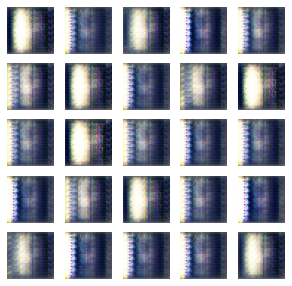

		Epoch 38
21.374250173568726
gan_loss: 0.014099296182394028 gan_acc: 1.0
dis_loss: 1.6027796268463135 dis_acc: 0.5078125


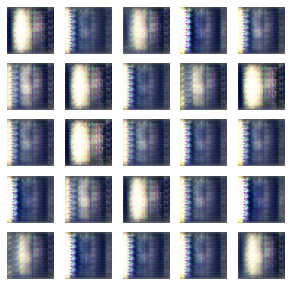

		Epoch 39
20.838576316833496
gan_loss: 0.012592319399118423 gan_acc: 1.0
dis_loss: 1.9791157245635986 dis_acc: 0.5


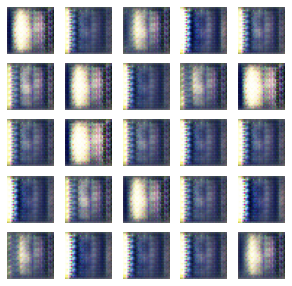

		Epoch 40
20.97781205177307
gan_loss: 0.011138645932078362 gan_acc: 1.0
dis_loss: 2.0926129817962646 dis_acc: 0.5


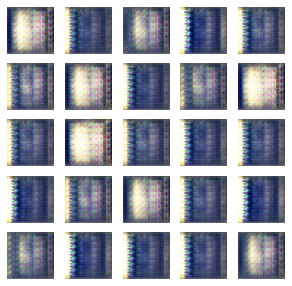

		Epoch 41
21.01585030555725
gan_loss: 0.020754177123308182 gan_acc: 1.0
dis_loss: 2.2439355850219727 dis_acc: 0.5


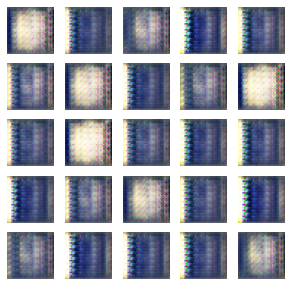

		Epoch 42
21.350743293762207
gan_loss: 0.21607039868831635 gan_acc: 1.0
dis_loss: 1.1520527601242065 dis_acc: 0.76953125


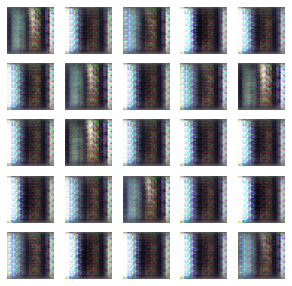

		Epoch 43
21.207167387008667
gan_loss: 0.17041665315628052 gan_acc: 0.9921875
dis_loss: 1.966850996017456 dis_acc: 0.43359375


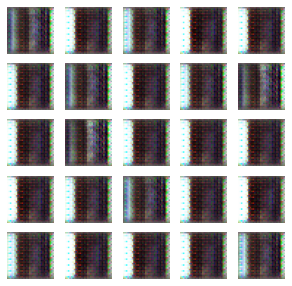

		Epoch 44
21.214502096176147
gan_loss: 1.2853024005889893 gan_acc: 0.09375
dis_loss: 1.1127809286117554 dis_acc: 0.76953125


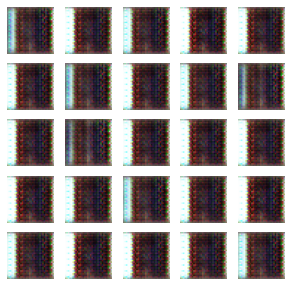

		Epoch 45
21.297024726867676
gan_loss: 6.407818794250488 gan_acc: 0.0
dis_loss: 1.459553599357605 dis_acc: 0.7890625


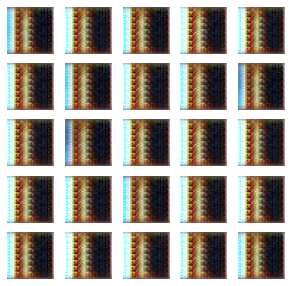

		Epoch 46
21.40436840057373
gan_loss: 0.3334125876426697 gan_acc: 0.9921875
dis_loss: 0.14954212307929993 dis_acc: 0.94921875


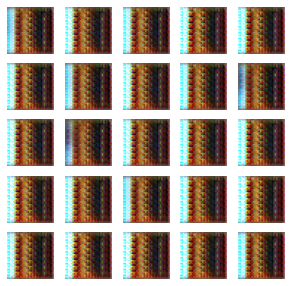

		Epoch 47
21.15569043159485
gan_loss: 17.51877212524414 gan_acc: 0.0
dis_loss: 0.5374964475631714 dis_acc: 0.9296875


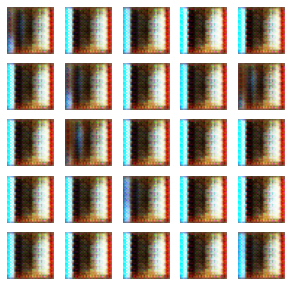

		Epoch 48
21.014390230178833
gan_loss: 18.29567527770996 gan_acc: 0.0
dis_loss: 6.28789758682251 dis_acc: 0.5


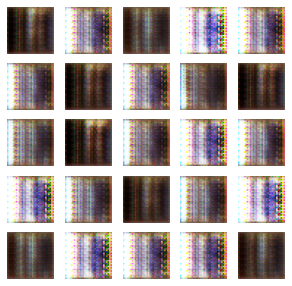

		Epoch 49
20.799736261367798
gan_loss: 1.403074860572815 gan_acc: 0.6015625
dis_loss: 0.26174041628837585 dis_acc: 0.86328125


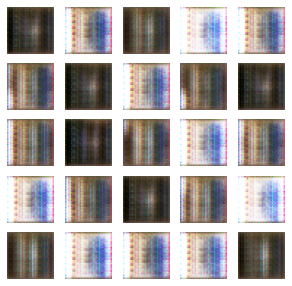

In [ ]:
for e in range(epochs):
    print(f'\t\tEpoch {e+delta}')
    start = time()
    for step in range(steps_per_epoch):
        true_examples = x[half*step:half*(step+1)]
        true_examples = np.reshape(true_examples, (true_examples.shape[0], 32, 32, 3))
        
        noise = np.random.randn(half, noise_size)
        gen_examples = generator.predict(noise)
        
        x_batch = np.concatenate([gen_examples, true_examples], axis=0)
        y_batch = np.array([0]*half + [1]*half)
        
        indices = np.random.choice(range(batch_size), batch_size, replace=False)
        
        x_batch = x_batch[indices]
        y_batch = y_batch[indices]
        
        discriminator.trainable = True
        discriminator.train_on_batch(x_batch, y_batch)
        discriminator.trainable = False
        
        gan_loss, gan_acc = gan.train_on_batch(noise, np.ones((half, 1)))
        dis_loss, dis_acc = discriminator.evaluate(x_batch, y_batch, verbose=False)
        stat[e+delta] = [gan_loss, gan_acc, dis_loss, dis_acc]
    
    print(time() - start)
    print(f'gan_loss: {gan_loss} gan_acc: {gan_acc}')
    print(f'dis_loss: {dis_loss} dis_acc: {dis_acc}')
    fig = plt.figure(figsize=(5,5))
    imgs = generator(seed, training=False)
    for i in range(len(imgs)):
        plt.subplot(5, 5, i+1)
        img = np.array(imgs[i] * 255, dtype='uint')
        plt.imshow(img)
        plt.axis('off')
    plt.savefig(f'/content/drive/MyDrive/gan/color_very_last_{e+delta}.png')
    plt.show()

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/test_mat/stat.txt', 'wa') as wr:
    wr.write('N\tgan_loss\tgan_acc\tdis_loss\tdis_acc\n')
    for i in stat:
        wr.write(f'{i}\t{stat[i][0]}\t{stat[i][1]}\t{stat[i][2]}\t{stat[i][3]}\n')